# Ising Model with Neural Network

Author: Shu-Hao Yeh (shuhaoyeh.ds@gmail.com)

In [1]:
# Environment setup
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from functools import partial

rc('text', usetex=True)

# to make this notebook's output stable across runs
def reset_graph(seed=3):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Ising Model

The Ising model, named after the German physicist Ernst Ising, is a mathematical model of ferromagnetism and also an important model system for understanding phase transitions. Consider a system of $N^2$ spins arranged on a $N$ by $N$ square lattice as illustrated in Fig.1:


<figure>
<img src = "./img/Ising_SqLatt.png", width=200, height=600>

<center><figcaption> Figure 1: Spins on a square lattice. </figcaption></center>
</figure>

Each spin $s_i$ can be in one of the two states, -1 (spin points down) or +1 (spin points up). Ising model suggests that the interaction energy is:

$-J\sum_{ij}s_i s_j \;,$
where $J$ is the coupling constant and only the interactions between the nearest neighbor spins are included. The total energy of the system is represented by its Hamiltonian:

$$\mathcal{H} = -J\sum_{ij}s_i s_j - H\sum_i s_i \;, \tag{1}$$
where $H$ is the external magnetic field. In all the simulations we assumed that there is no external magnetic field applied to the system $(H = 0)$ and the coupling constant is positive $(J > 0)$.

## 1 - Monte Carlo Simulation

The following code simulates the 2D Ising model using the Metropolis algorithm:

1. Initialize the spin configuration.
2. Randomly select one spin in the lattice and flip the sign. $\Delta E = E_{\mathrm{new}} - E_{\mathrm{old}}$.
3. If the total energy of the new spin configuration is lower ($\Delta E < 0$), accept the move. Otherwise draw a random number $x$ between 0 and 1, and accept the change only if $x \le \exp(-\Delta E / k_B T)$.
4. Repeat Step 2 and 3.

### Parameters for Monte Carlo Simulation

In [2]:
N = 30 # Lattice points on each edge
T = 8 # Temperature (in the unit of J/k_B), the critical temperature in this case is 2/log(1+sqrt(2)) ~= 2.269
ns = 5000 # Number of Monte Carlo steps

### Initialization

The initial spin configuration is set to all spins pointing up ($s_i = 1$).

(0.5, 30.5, 30.5, 0.5)

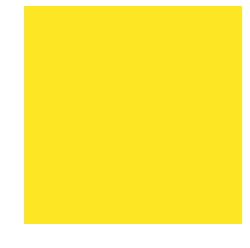

In [3]:
# Initial state
reset_graph()
M = np.ones((N,N), dtype=int)

fig, ax = plt.subplots()
ax.imshow(M, extent=[0.5, N + 0.5, N + 0.5 , 0.5], vmin=-1, vmax=1)
plt.axis('off')

### Setup the energy evaluation function

The code below defines the function that calculates the total energy of the system depending on the spin configuration.

In [4]:
def estE(M): # Energy evaluation function
    total = 0
    for i in range(N-1): 
        total -= np.sum(np.multiply(M[i,:] , M[i+1,:])) # Sum over element-wise multiplication between neighbor rows
        
    for i in range(N-1):
        total -= np.sum(np.multiply(M[:,i] , M[:,i+1])) # Sum over element-wise multiplication between neighbor columns
    
    return total

### Monte Carlo Iterations

In [5]:
# Start the Monte Carlo iterations
for i in range(ns):
    rele = np.random.randint(N**2)
    m,n = divmod(rele,N)
    newM = np.copy(M)
    newM[m,n] *= -1
    dE = estE(newM) - estE(M)
    if dE <= 0:
        np.copyto(M,newM)
    elif np.random.random_sample() <= np.exp(-dE/T):
        np.copyto(M,newM)
    
print("Complete {:d} steps".format(ns))

Complete 5000 steps


## Visualize the results

The final spin configuration is shown below with its corresponding magnetization: $$\langle M \rangle = \frac{1}{N^2} \sum_i^{N^2} s_i \;. \tag{2}$$ The yellow and blue color in the figure below represent spin up and down respectively.

<M> =  0.022222222222222223


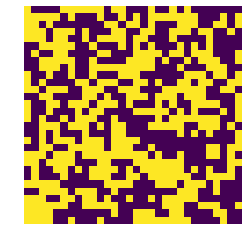

In [6]:
fig, ax = plt.subplots()
ax.imshow(M, extent=[0.5, N + 0.5, N + 0.5 , 0.5], vmin=-1, vmax=1)
plt.axis('off')

print("<M> = ", np.sum(M)/(N**2))

## 2 - Discriminating between the low- and high-temperature phase by neural network

Recently machine learning has been exploited in studying phases and phase transitions in condensed-matter research. The code below demonstrates a trained neural network which is capable of descriminating between the low-temperature ferromagnetic phase and the high-temperature paramagnetic phase in the ferromagnetic Ising model. The trained neural network (trained on square lattice) can be further exploited to estimate the critical temperature of Ising model with a different lattice architecture (ex. triangular lattice, Fig.2).

<figure>
<img src = "./img/Ising_TriLatt.png", width=200, height=600>

<center><figcaption> Figure 2: Spins on a triangular lattice. </figcaption></center>
</figure>



### Parameters for the neural network

The neural network is composed of an input layer of $N^2$ neurons with values assigned according to the spin configurations, a hidden layer of $N^2$ neurons, and an output layer of two neurons that categorize the phases. In the output layer, we labeled the low- and high-temperature phase as 0 and 1, respectively.

In [7]:
n_inputs = 30*30
n_hidden1 = 100
n_outputs = 2

In [8]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

### Cost function and optimizer

We use the softmax cross-entropy cost function with an $L2$ regularization term to prevent overfitting. The neural network is trained with using the Adam optimization.

In [9]:
scale = 1E-2 # l2 regularization hyperparameter

my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.elu,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    logits = my_dense_layer(hidden1, n_outputs, activation=None, name="outputs")

In [10]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [11]:
learning_rate = 1E-3

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [12]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [14]:
n_epochs = 200
batch_size = 5000

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

### Define the training, evaluation, and test set

The training set is composed of 2000 samples per temperature value, where 40 linearly-spaced temperature values are used. To evenly include spin configurations in the low- or high-temperature phases, the temperature range is set from 1 to 3.54 $J/k_B$ (the critical temperature of square-lattice Ising model is $2/\ln\left(1+\sqrt{2}\right) \approx 2.269 J/k_B$). The spin configurations of square-lattice Ising model are generated by Monte Carlo simulations introduced above, and the initial spin configurations across the samples are evenly set to either all spins pointing up or down. 

The validation set is generated in a similar fashion, the only difference is 500 samples are used per temperature value instead of 2000. In the current tutorial, two test sets are used. Each test set consists of 250 samples per temperature value, using 41 linearly-spaced temperature values (we also set the lowest 20 temperature values below the theoretical critical temperature of the corresponding Ising model). One of the test sets is the spin configurations generated from the square-lattice Ising model, using the same procedure as generating the training set, but using a different random seed. The other test set consists of the spin configurations of triangular-lattice Ising model generated by Monte Carlo simulations with a different temperature range (from 2 to 5.28 $J/k_B$, to include the critical temperature of triangular lattice Ising model, which is $4/\ln~3 \approx 3.641 J/k_B$).

In [15]:
Xdata = np.loadtxt("./Xtrain_JC30.txt", dtype=int)
X_test_sq = np.loadtxt("./Xtest_JC30.txt", dtype=int) # Square-lattice test set
X_test_tri = np.loadtxt("./TRIANGXtest_JC30.txt", dtype=int) # Triangular-lattice test set

valid_idx = np.kron(np.ones(40,dtype=int), np.arange(2000,2500,dtype=int)) + np.kron(2500*np.arange(0,40,dtype=int),np.ones(500,dtype=int))
train_idx = np.kron(np.ones(40,dtype=int), np.arange(0,2000,dtype=int)) + np.kron(2500*np.arange(0,40,dtype=int),np.ones(2000,dtype=int))

X_valid = Xdata[valid_idx]
X_train = Xdata[train_idx]
y_train = np.concatenate((np.zeros(40000, dtype=int), np.ones(40000, dtype=int)))
y_valid = np.concatenate((np.zeros(10000, dtype=int), np.ones(10000, dtype=int)))
y_test = np.concatenate((np.zeros(5250, dtype=int), np.ones(5000, dtype=int)))

In [16]:
cost_history = np.zeros(shape=[n_epochs+1],dtype=float)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs + 1):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})        
        cost_history[epoch] = acc_batch
        
        if epoch % 10 == 0:
            print("Epoch:", epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch: 0 Batch accuracy: 0.7506 Validation accuracy: 0.73345
Epoch: 10 Batch accuracy: 0.967 Validation accuracy: 0.9681
Epoch: 20 Batch accuracy: 0.9846 Validation accuracy: 0.98045
Epoch: 30 Batch accuracy: 0.9856 Validation accuracy: 0.98365
Epoch: 40 Batch accuracy: 0.9862 Validation accuracy: 0.9854
Epoch: 50 Batch accuracy: 0.988 Validation accuracy: 0.98575
Epoch: 60 Batch accuracy: 0.9868 Validation accuracy: 0.9864
Epoch: 70 Batch accuracy: 0.9874 Validation accuracy: 0.9876
Epoch: 80 Batch accuracy: 0.9888 Validation accuracy: 0.98815
Epoch: 90 Batch accuracy: 0.9884 Validation accuracy: 0.988
Epoch: 100 Batch accuracy: 0.9868 Validation accuracy: 0.98805
Epoch: 110 Batch accuracy: 0.9892 Validation accuracy: 0.98885
Epoch: 120 Batch accuracy: 0.9906 Validation accuracy: 0.98885
Epoch: 130 Batch accuracy: 0.988 Validation accuracy: 0.98805
Epoch: 140 Batch accuracy: 0.9898 Validation accuracy: 0.98825
Epoch: 150 Batch accuracy: 0.9886 Validation accuracy: 0.98835
Epoch: 160 B

In [17]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test_sq[:]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred1 = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


## Visualize the results

Text(0.5, 1.0, 'Model accuracy')

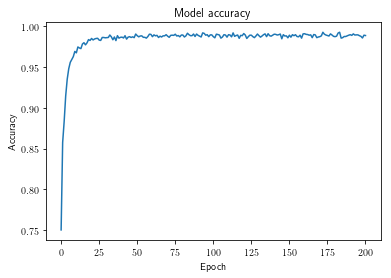

In [18]:
plt.plot(range(len(cost_history)),cost_history) # Print epoch vs accuracy
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model accuracy")

Test Accuracy: 97.72682926829268 %


Text(0.5, 1.0, 'Square-lattice Ising Model')

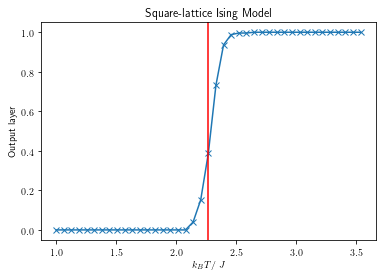

In [19]:
print ("Test Accuracy:", 100 * (1-np.mean(np.abs(y_test - y_pred1))), "%")
Tsq=np.array(np.mat('1.0000000000000000 1.0634592657106510 1.1269185314213019 1.1903777971319529 1.2538370628426039 1.3172963285532548 1.3807555942639058 1.4442148599745568 1.5076741256852078 1.5711333913958587 1.6345926571065097 1.6980519228171607 1.7615111885278116 1.8249704542384626 1.8884297199491136 1.9518889856597645 2.0153482513704155 2.0788075170810667 2.1422667827917179 2.2057260485023691 2.2691853142130203 2.3326445799236715 2.3961038456343227 2.4595631113449739 2.5230223770556250 2.5864816427662762 2.6499409084769274 2.7134001741875786 2.7768594398982298 2.8403187056088810 2.9037779713195322 2.9672372370301834 3.0306965027408346 3.0941557684514858 3.1576150341621370 3.2210742998727881 3.2845335655834393 3.3479928312940905 3.4114520970047417 3.4749113627153929 3.5383706284260401'))
plt.plot(Tsq.reshape(41,1), np.mean(y_pred1.reshape(-1, 250), axis=1), marker="x")
plt.xlabel(r"$k_B T /\;J$")
plt.ylabel('Output layer')
plt.axvline(x=2/np.log(1+np.sqrt(2)), color='r')
plt.title("Square-lattice Ising Model")

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test_tri[:]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred2 = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Test Accuracy: 97.45365853658537 %


Text(0.5, 1.0, 'Triangular-lattice Ising Model')

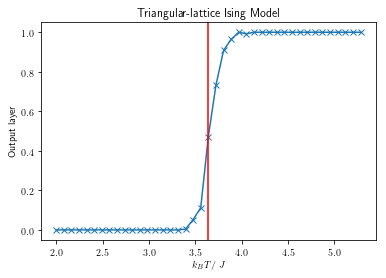

In [21]:
print ("Test Accuracy:", 100 * (1-np.mean(np.abs(y_test - y_pred2))), "%")
Ttri=np.array(np.mat('2.0000000000000000 2.0820478453253499 2.1640956906506998 2.2461435359760498 2.3281913813013997 2.4102392266267496 2.4922870719520995 2.5743349172774495 2.6563827626027994 2.7384306079281493 2.8204784532534992 2.9025262985788491 2.9845741439041991 3.0666219892295490 3.1486698345548989 3.2307176798802488 3.3127655252055987 3.3948133705309487 3.4768612158562986 3.5589090611816485 3.6409569065069984 3.7230047518323484 3.8050525971576983 3.8871004424830482 3.9691482878083981 4.0511961331337485 4.1332439784590989 4.2152918237844492 4.2973396691097996 4.3793875144351500 4.4614353597605003 4.5434832050858507 4.6255310504112011 4.7075788957365514 4.7896267410619018 4.8716745863872521 4.9537224317126025 5.0357702770379529 5.1178181223633032 5.1998659676886536 5.2819138130140004'))
plt.plot(Ttri.reshape(41,1), np.mean(y_pred2.reshape(-1, 250), axis=1), marker="x")
plt.xlabel(r"$k_B T /\;J$")
plt.ylabel('Output layer')
plt.axvline(x=4/np.log(3), color='r')
plt.title("Triangular-lattice Ising Model")

Ideally, the neural network should categorize the spin configurations generated below or above $T_c$ as in the low- or high-temperature phase, respectively. The red vertical line represents the critical temperature in the corresponding lattice structure. The average outputs of the neural network cross the value of 0.5 at temperature close to the critical temperature $T_c$. The neural network trained under square-lattice Ising model is capable of predicting the low- and high-temperature phases in the triangular-lattice Ising model.